In [3]:
import math
from typing import Optional, Tuple, Union, List

import torch
from torch import nn

import matplotlib.pyplot as plt

In [8]:
x = torch.arange(-10, 10, 0.01)

In [4]:
# A fancy activation function
class Swish(nn.Module):

    def forward(self, x):
        return x * torch.sigmoid(x)

In [11]:
r = nn.ReLU()
y2 = r(x)

In [9]:
s = Swish()
y = s(x)

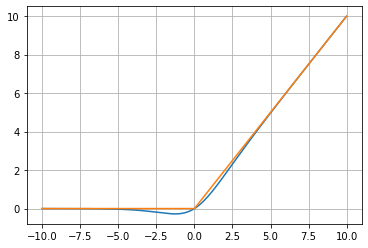

In [12]:
plt.plot(x, y)
plt.plot(x, y2)
plt.grid(True)
plt.show()

In [15]:
torch.arange(4)

tensor([0, 1, 2, 3])

In [27]:
time_dim = 15

'''if time_dim >= 8 and time_dim < 16:
    raise ValueError(f'time_dim must be: time_dim < 8 or time_dim >= 16')'''

half_dim   = time_dim // 8

emb = math.log(10_000) / (half_dim - 1)
print(emb)
emb = torch.exp(torch.arange(half_dim) * -emb)
print(emb)

ZeroDivisionError: float division by zero

In [45]:
class TimeEmbedding(nn.Module):
    
    def __init__(self, time_dim : int, device = 'cpu'):
        super(TimeEmbedding, self).__init__()
        
        self.time_dim = time_dim
        self.half_dim = time_dim // 8
        
        ara = torch.arange(self.half_dim, device=device)
        div = -(math.log(10_000) / (self.half_dim - 1))
        
        self.emb = torch.exp(ara * div)
        
        # Layers
        
        self.linear1 = nn.Linear(self.time_dim // 4, self.time_dim)
        self.linear2 = nn.Linear(self.time_dim, self.time_dim)
        
        self.swish   = Swish()
        
        print(self.emb[None, :].shape)
        
    def forward(self, x):
        
        out = x[:, None] * self.emb[None, :]
        print(out.shape)
        out = self.swish(self.linear1(out))
        
        return self.linear2(out)
        
        

In [46]:
x_test = torch.arange(0, 1, 0.1)
x_test

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000])

In [48]:
x_test = torch.rand((5,5))
x_test

tensor([[0.9909, 0.4458, 0.6178, 0.8257, 0.6781],
        [0.2981, 0.6685, 0.5953, 0.0608, 0.4795],
        [0.0478, 0.0929, 0.7673, 0.6236, 0.7600],
        [0.9852, 0.7126, 0.6810, 0.7945, 0.6050],
        [0.5724, 0.7059, 0.9505, 0.7144, 0.2210]])

In [49]:
TE = TimeEmbedding(20)
y = TE(x_test)
y

torch.Size([1, 2])


RuntimeError: The size of tensor a (5) must match the size of tensor b (2) at non-singleton dimension 2

In [43]:
# The time embedding 
class TimeEmbedding(nn.Module):
    """
    ### Embeddings for $t$
    """

    def __init__(self, n_channels: int):
        """
        * `n_channels` is the number of dimensions in the embedding
        """
        super().__init__()
        self.n_channels = n_channels
        # First linear layer
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Activation
        self.act = Swish()
        # Second linear layer
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        # Create sinusoidal position embeddings
        # [same as those from the transformer](../../transformers/positional_encoding.html)
        #
        # \begin{align}
        # PE^{(1)}_{t,i} &= sin\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg) \\
        # PE^{(2)}_{t,i} &= cos\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg)
        # \end{align}
        #
        # where $d$ is `half_dim`
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        # Transform with the MLP
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        #
        return emb

In [44]:
TE = TimeEmbedding(100)
y = TE(x_test)
y

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x24 and 25x100)

In [13]:
math.log(10_000)

9.210340371976184

In [ ]:
# The time embedding 
class TimeEmbedding(nn.Module):
    """
    ### Embeddings for $t$
    """

    def __init__(self, n_channels: int):
        """
        * `n_channels` is the number of dimensions in the embedding
        """
        super().__init__()
        self.n_channels = n_channels
        # First linear layer
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Activation
        self.act = Swish()
        # Second linear layer
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        # Transform with the MLP
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        #
        return emb

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim):
        super(DoubleConv, self).__init__()
        
        self.conv1 = nn.Sequential(      
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.Swish())
        
        self.conv2 = nn.Sequential( 
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.Swish())
        
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()
            
        self.linear = nn.Linear(time_dim, out_channels)
        
    def forward(self, x, t):
        
        out = self.conv1(x)
        out += self.linear(t)[:, :, None, None]
        out = self.conv2(out)
        
        
        return out + self.shorcut(x)

In [53]:
class cu():
    
    def __init__(self, p):
        self.p = p
        
    
    if self.p:
        def cuz():
            print('pai')
            
    else:
        def cuz():
            print('mae')

NameError: name 'self' is not defined

In [ ]:
# Residual blocks include 'skip' connections
class ResidualBlock(nn.Module):
    """
    ### Residual block
    A residual block has two convolution layers with group normalization.
    Each resolution is processed with two residual blocks.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, n_groups: int = 32):
        """
        * `in_channels` is the number of input channels
        * `out_channels` is the number of input channels
        * `time_channels` is the number channels in the time step ($t$) embeddings
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()
        # Group normalization and the first convolution layer
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # Group normalization and the second convolution layer
        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        # Linear layer for time embeddings
        self.time_emb = nn.Linear(time_channels, out_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # First convolution layer
        h = self.conv1(self.act1(self.norm1(x)))
        # Add time embeddings
        h += self.time_emb(t)[:, :, None, None]
        # Second convolution layer
        h = self.conv2(self.act2(self.norm2(h)))

        # Add the shortcut connection and return
        return h + self.shortcut(x)


In [ ]:
# Ahh yes, magical attention...
class AttentionBlock(nn.Module):
    """
    ### Attention block
    This is similar to [transformer multi-head attention](../../transformers/mha.html).
    """

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
        """
        * `n_channels` is the number of channels in the input
        * `n_heads` is the number of heads in multi-head attention
        * `d_k` is the number of dimensions in each head
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels
        # Normalization layer
        self.norm = nn.GroupNorm(n_groups, n_channels)
        # Projections for query, key and values
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        # Linear layer for final transformation
        self.output = nn.Linear(n_heads * d_k, n_channels)
        # Scale for dot-product attention
        self.scale = d_k ** -0.5
        #
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        # Get shape
        batch_size, n_channels, height, width = x.shape
        # Change `x` to shape `[batch_size, seq, n_channels]`
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # Get query, key, and values (concatenated) and shape it to `[batch_size, seq, n_heads, 3 * d_k]`
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        # Split query, key, and values. Each of them will have shape `[batch_size, seq, n_heads, d_k]`
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        # Calculate scaled dot-product $\frac{Q K^\top}{\sqrt{d_k}}$
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        # Softmax along the sequence dimension $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
        attn = attn.softmax(dim=1)
        # Multiply by values
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        # Reshape to `[batch_size, seq, n_heads * d_k]`
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        # Transform to `[batch_size, seq, n_channels]`
        res = self.output(res)

        # Add skip connection
        res += x

        # Change to shape `[batch_size, in_channels, height, width]`
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        #
        return res


In [56]:
d_k        = 5
n_channels = 4

m = d_k if d_k is not None else n_channels
m

5

In [85]:
class ImageAttention(nn.Module):
    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):

        
        super(Attention, self).__init__()

        self.n_heads = n_heads
        self.d_k     = d_k if d_k is not None else n_channels
        self.scale   = d_k ** -0.5
        
        # self.norm_layer   = nn.BatchNorm2d(n_channels)
        self.linear_layer = nn.Linear(n_channels, n_heads * d_k * 3)
        self.output_layer = nn.Linear(n_heads * d_k, n_channels)
        

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):

        batch_size, n_channels, height, width = x.shape
        
        _ = t
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        
        QKV = self.linear_layer(x)
        QKV = QKV.view(batch_size, -1, self.n_heads, 3 * self.d_k)
        
        Q, K, V = torch.chunk(QKV, 3, dim=-1)
        
        att = (torch.einsum('BIHD, BJHD -> BIJH', Q, K) * self.scale).softmax(dim=1)
        
        out = torch.einsum('BIJH, BJHD -> BIHD', att, V)
        out = out.reshape(batch_size, -1, self.n_heads*self.d_k)
        out = self.output_layer(out)
        out += x
        
        return out.permute(0, 2, 1).view(batch_size, n_channels, height, width)


In [86]:
a = Attention(3, 4, 2)

In [88]:
x = torch.rand((1, 3, 5, 4))
a(x).shape

torch.Size([1, 3, 5, 4])

In [ ]:
# Ahh yes, magical attention...
class Attention(nn.Module):


    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):

        
        super(Attention, self).__init__()

        self.n_heads = n_heads
        self.d_k     = d_k if d_k is not None else n_channels
        self.scale   = d_k ** -0.5
        
        self.norm_layer   = nn.BatchNorm2d(n_channels)
        self.linear_layer = nn.Linear(n_channels, n_heads * d_k * 3)
        self.output_layer = nn.Linear(n_heads * d_k, n_channels)
        

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        # Get shape
        
        batch_size, n_channels, height, width = x.shape
        
        # Change `x` to shape `[batch_size, seq, n_channels]`
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        
        
        
        # Get query, key, and values (concatenated) and shape it to `[batch_size, seq, n_heads, 3 * d_k]`
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        # Split query, key, and values. Each of them will have shape `[batch_size, seq, n_heads, d_k]`
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        # Calculate scaled dot-product $\frac{Q K^\top}{\sqrt{d_k}}$
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        # Softmax along the sequence dimension $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
        attn = attn.softmax(dim=1)
        # Multiply by values
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        # Reshape to `[batch_size, seq, n_heads * d_k]`
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        # Transform to `[batch_size, seq, n_channels]`
        res = self.output(res)

        # Add skip connection
        res += x

        # Change to shape `[batch_size, in_channels, height, width]`
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        #
        return res


In [ ]:
class UNetEncoder(nn.Module):
    
    def __init__(self, in_channels, out_channels, time_dim, att):
        super(UNetEncoder, self).__init__()
        
        self.conv = DoubleConv(in_channels, out_channels, time_dim)        
        self.att  = ImageAttention(out_channels) if att else nn.Identity()
        
    def forward(self, x, t):
        return self.att(self.conv(x, t))

In [ ]:
class DownBlock(nn.Module):
    """
    ### Down block
    This combines `ResidualBlock` and `AttentionBlock`. These are used in the first half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x

In [ ]:
class UNetDecoder(nn.Module):
    
    def __init__(self, in_channels, out_channels, time_dim, att):
        super(UNetDecoder, self).__init__()
        
        self.conv = DoubleConv(in_channels + out_channels, out_channels, time_dim)        
        self.att  = ImageAttention(out_channels) if att else nn.Identity()
        
    def forward(self, x, t):
        return self.att(self.conv(x, t))

In [ ]:
class UpBlock(nn.Module):
    """
    ### Up block
    This combines `ResidualBlock` and `AttentionBlock`. These are used in the second half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x

In [ ]:
class UNetBottleneck(nn.Module):
    
    def __init__(self, in_channels, time_dim):
        super(UNetBottleneck, self).__init__()
        
        self.conv1 = DoubleConv(in_channels, in_channels, time_dim) 
        self.conv2 = DoubleConv(in_channels, in_channels, time_dim) 
        self.att   = ImageAttention(in_channels)
        
    def forward(self, x, t):
        out = self.att(self.conv1(x, t))
        return self.conv2(out, t)

In [ ]:
class MiddleBlock(nn.Module):
    """
    ### Middle block
    It combines a `ResidualBlock`, `AttentionBlock`, followed by another `ResidualBlock`.
    This block is applied at the lowest resolution of the U-Net.
    """

    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x

In [ ]:
class Upsample(nn.Module):
    """
    ### Scale up the feature map by $2 \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)

In [ ]:
class Downsample(nn.Module):
    """
    ### Scale down the feature map by $\frac{1}{2} \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    
    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[int]] = (False, False, True, True),
                 n_blocks: int = 2):
       
        super().__init__()
        n_resolutions = len(ch_mults)
        
        self.down = nn.ModuleList()
        self.up   = nn.ModuleList()
        
        out_channels = in_channels = n_channels
        
        self.image_transform = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))
        self.time_emb        = TimeEmbedding(n_channels * 4)
        
        for i in range(n_resolutions):
            
            out_channels = in_channels * ch_mults[i]            
            for _ in range(n_blocks):
                self.down.append(UNetEncoder(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            
            if i < n_resolutions - 1:
                self.down.append(nn.Conv2d(in_channels, in_channels, (3, 3), (2, 2), (1, 1)))
                
        self.middle = UNetBottleneck(out_channels, n_channels * 4)
        
        in_channels = out_channels
        
        for i in reversed(range(n_resolutions)):
            
            out_channels = in_channels
            
            for _ in range(n_blocks):
                self.up.append(UNetDecoder(in_channels, out_channels, n_channels * 4, is_attn[i]))
                
            out_channels = in_channels // ch_mults[i]
            self.up.append(UNetDecoder(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            
            
            if i > 0:
                self.up.append(nn.ConvTranspose2d(in_channels, in_channels, (4, 4), (2, 2), (1, 1)))
                
        self.norm = nn.BatchNorm2d(n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))
        
    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size]`
        """

        # Get time-step embeddings
        t = self.time_emb(t)

        # Get image projection
        x = self.image_proj(x)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, t)

        # Second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                #
                x = m(x, t)

        # Final normalization and convolution
        return self.final(self.act(self.norm(x)))

In [ ]:
# The core class definition (aka the important bit)
class UNet(nn.Module):
    """
    ## U-Net
    """

    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[int]] = (False, False, True, True),
                 n_blocks: int = 2):
        """
        * `image_channels` is the number of channels in the image. $3$ for RGB.
        * `n_channels` is number of channels in the initial feature map that we transform the image into
        * `ch_mults` is the list of channel numbers at each resolution. The number of channels is `ch_mults[i] * n_channels`
        * `is_attn` is a list of booleans that indicate whether to use attention at each resolution
        * `n_blocks` is the number of `UpDownBlocks` at each resolution
        """
        super().__init__()

        # Number of resolutions
        n_resolutions = len(ch_mults)

        # Project image into feature map
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

        # Time embedding layer. Time embedding has `n_channels * 4` channels
        self.time_emb = TimeEmbedding(n_channels * 4)

        # #### First half of U-Net - decreasing resolution
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        
        
        for i in range(n_resolutions):
            
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            # Down sample at all resolutions except the last
            
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        # #### Second half of U-Net - increasing resolution
        up = []
        # Number of channels
        in_channels = out_channels
        # For each resolution
        for i in reversed(range(n_resolutions)):
            # `n_blocks` at the same resolution
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            # Final block to reduce the number of channels
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            # Up sample at all resolutions except last
            if i > 0:
                up.append(Upsample(in_channels))

        # Combine the set of modules
        self.up = nn.ModuleList(up)

        # Final normalization and convolution layer
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size]`
        """

        # Get time-step embeddings
        t = self.time_emb(t)

        # Get image projection
        x = self.image_proj(x)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, t)

        # Second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                #
                x = m(x, t)

        # Final normalization and convolution
        return self.final(self.act(self.norm(x)))